# Variational approach to continuum thermodynamics

## Time discretization and integration

**TODO:** Adapt the description to fit with the implementation.

The notebook demonstrates the derivation of both rate and increment based formulation of the total potential that is solved using in terms of 
 - rates of internal variables
 - increments of internal variables 

The minimization of the dissipation potential is done for an increment $\Delta \Pi$ defined in the time interval $\Delta t$. This requires an integration over the increment $t \in (t_n, t_{n+1})$, where $t_{n+1} = t_{n} + \Delta t$.

$$
\Delta \Pi = \int_{t_n}^{t_{n+1}} \dot{\psi} \, \mathrm{d}t
+ \int_{t_n}^{t_{n+1}} \dot{\phi} \, \mathrm{d}t
$$

$$
\Delta \Pi = \psi(t_{n+1}) - \psi(t_n) 
+ \int_{t_n}^{t_{n+1}} \dot{\phi} \, \mathrm{d}t
$$

$$
\Delta \Pi = \psi(\varepsilon_{n+1}, \mathcal{E}_{n+1}) 
           - \psi(\varepsilon_{n}, \mathcal{E}_{n}) 
+ \Delta t \phi(\mathcal{E}_n, \dot{\mathcal{E}}_n)
$$


## Three types of viscoelastic implementations 

In [21]:
%matplotlib widget
import sympy as sp
import numpy as np
from scipy.optimize import minimize
from bmcs_utils.api import Cymbol, cymbols
import matplotlib.pyplot as plt
from math import pi
sp.init_printing()


In [4]:
# Define symbols
eps, eps_v = cymbols(r'\varepsilon \varepsilon_\mathrm{v}', codenames='epsilon epsilon_v', real=True)
E = Cymbol(r'E', codename='E', positive=True, real=True)
eta = Cymbol(r'\eta', codename='eta', positive=True, real=True)
dot_eps = Cymbol(r'\dot{\varepsilon}', codename='dot_eps', real=True)
dot_eps_v = Cymbol(r'\dot{\varepsilon}_\mathrm{v}', codename='dot_eps_v', real=True)

# Define the total strain as the sum of elastic and viscous parts
eps_e_ = eps - eps_v

# Define Helmholtz free energy Psi
psi_ = sp.Rational(1, 2) * E * eps_e_**2

# Define dissipation potential Phi
phi_ = sp.Rational(1, 2) * eta * dot_eps_v**2

# Define the stress-strain relationship for the elastic part
sig_ = psi_.diff(eps)

In [5]:
gamma_mech_ = sp.simplify(-psi_.diff(eps_v) * dot_eps_v)
gamma_mech_

In [6]:
class BasePsi:
    d_t = Cymbol(r'\Delta t', codename='d_t')
    eps_n = Cymbol(r'\varepsilon^{(n)}', codename='eps_n')
    eps_v_n = Cymbol(r'\varepsilon_\mathrm{v}^{(n)}', codename='eps_v_n')
    dot_eps_n = Cymbol(r'\dot{\varepsilon}^{(n)}', codename='dot_eps_n')
    dot_eps_v_n = Cymbol(r'\dot{\varepsilon}_\mathrm{v}^{(n)}', codename='dot_eps_v_n')
    delta_eps_n = Cymbol(r'\Delta{\varepsilon}^{(n)}', codename='delta_eps_n')
    delta_eps_v_n = Cymbol(r'\Delta{\varepsilon}_\mathrm{v}^{(n)}', codename='delta_eps_v_n')

    def __init__(self, rate_form=True):
        self.rate_form = rate_form

    def lambdify_functions(self, expr, variables):
        return sp.lambdify(variables, expr, 'numpy', cse=True)

class PiIncrPsiRateEps(BasePsi):
    def __init__(self, rate_form=True):
        super().__init__(rate_form)
        self.gamma_n = gamma_mech_.subs({eps: self.eps_n, eps_v: self.eps_v_n, dot_eps_v: self.dot_eps_v_n})
        self.gamma_n1 = gamma_mech_.subs({eps: self.eps_n + self.dot_eps_n * self.d_t, eps_v: self.eps_v_n + self.dot_eps_v_n * self.d_t, dot_eps_v: self.dot_eps_v_n})
        self.Pi = - self.gamma_n1 + self.gamma_n + self.d_t * phi_.subs({dot_eps_v: self.dot_eps_v_n})
        self.jac_Pi = sp.diff(self.Pi, self.dot_eps_v_n)
        self.hes_Pi = sp.diff(self.jac_Pi, self.dot_eps_v_n)
        self.sig_n1 = sig_.subs({eps: self.eps_n + self.dot_eps_n * self.d_t, eps_v: self.eps_v_n + self.dot_eps_v_n * self.d_t})
        self.get_Pi = self.lambdify_functions(self.Pi, (self.eps_n, self.dot_eps_n, self.eps_v_n, self.dot_eps_v_n, self.d_t, E, eta))
        self.get_jac_Pi = self.lambdify_functions(self.jac_Pi, (self.eps_n, self.dot_eps_n, self.eps_v_n, self.dot_eps_v_n, self.d_t, E, eta))
        self.get_hes_Pi = self.lambdify_functions(self.hes_Pi, (self.eps_n, self.dot_eps_n, self.eps_v_n, self.dot_eps_v_n, self.d_t, E, eta))
        self.get_sig_n1 = self.lambdify_functions(self.sig_n1, (self.eps_n, self.dot_eps_n, self.eps_v_n, self.dot_eps_v_n, self.d_t, E, eta))

class PiRatePsiRateEps(BasePsi):
    def __init__(self, rate_form=True):
        super().__init__(rate_form)
        self.Pi = (-gamma_mech_ + phi_ * self.d_t).subs({eps_v: self.eps_v_n + self.dot_eps_v_n * self.d_t, 
                                                 dot_eps_v: self.dot_eps_v_n,
                                                 eps: self.eps_n + self.dot_eps_n * self.d_t, 
                                                 dot_eps: self.dot_eps_n})
        self.jac_Pi = sp.diff(self.Pi, self.dot_eps_v_n)
        self.hes_Pi = sp.diff(self.jac_Pi, self.dot_eps_v_n)
        self.sig_n1 = sig_.subs({eps: self.eps_n + self.dot_eps_n * self.d_t, eps_v: self.eps_v_n + self.dot_eps_v_n * self.d_t})
        self.get_Pi = self.lambdify_functions(self.Pi, (self.eps_n, self.dot_eps_n, self.eps_v_n, self.dot_eps_v_n, self.d_t, E, eta))
        self.get_jac_Pi = self.lambdify_functions(self.jac_Pi, (self.eps_n, self.dot_eps_n, self.eps_v_n, self.dot_eps_v_n, self.d_t, E, eta))
        self.get_hes_Pi = self.lambdify_functions(self.hes_Pi, (self.eps_n, self.dot_eps_n, self.eps_v_n, self.dot_eps_v_n, self.d_t, E, eta))
        self.get_sig_n1 = self.lambdify_functions(self.sig_n1, (self.eps_n, self.dot_eps_n, self.eps_v_n, self.dot_eps_v_n, self.d_t, E, eta))

class PiRatePsiIncrEps(BasePsi):
    def __init__(self, rate_form=False):
        super().__init__(rate_form)
        self.Pi = (-gamma_mech_ + phi_ * self.d_t).subs({eps_v: self.eps_v_n + self.delta_eps_v_n, 
                                                 eps: self.eps_n + self.delta_eps_n, 
                                                 dot_eps: self.delta_eps_n / self.d_t,
                                                 dot_eps_v: self.delta_eps_v_n / self.d_t})
        self.jac_Pi = sp.diff(self.Pi, self.delta_eps_v_n) * self.d_t
        self.hes_Pi = sp.diff(self.jac_Pi, self.delta_eps_v_n)
        self.sig_n1 = sig_.subs({eps: self.eps_n + self.delta_eps_n, eps_v: self.eps_v_n + self.delta_eps_v_n})
        self.get_Pi = self.lambdify_functions(self.Pi, (self.eps_n, self.delta_eps_n, self.eps_v_n, self.delta_eps_v_n, self.d_t, E, eta))
        self.get_jac_Pi = self.lambdify_functions(self.jac_Pi, (self.eps_n, self.delta_eps_n, self.eps_v_n, self.delta_eps_v_n, self.d_t, E, eta))
        self.get_hes_Pi = self.lambdify_functions(self.hes_Pi, (self.eps_n, self.delta_eps_n, self.eps_v_n, self.delta_eps_v_n, self.d_t, E, eta))
        self.get_sig_n1 = self.lambdify_functions(self.sig_n1, (self.eps_n, self.delta_eps_n, self.eps_v_n, self.delta_eps_v_n, self.d_t, E, eta))

# Create instances of each class
pi_rate_psi_rate_eps = PiRatePsiRateEps()
pi_incr_psi_rate_eps = PiIncrPsiRateEps()
pi_rate_psi_incr_eps = PiRatePsiIncrEps()
pi_rpre = pi_rate_psi_rate_eps
pi_ipre = pi_incr_psi_rate_eps
pi_rpie = pi_rate_psi_incr_eps


## Verification test

Find $\Delta \varepsilon_\mathrm{v}$ for given starting vector and verify  that the lamdfified functions all attain the minimum at that point.

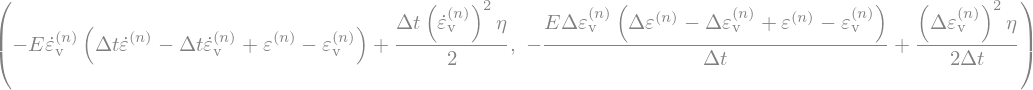

In [7]:
pi_rpre.Pi, pi_rpie.Pi

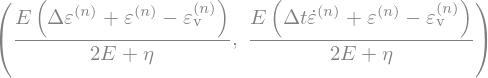

In [8]:
rpre_eps_v_solved = sp.solve(pi_rpre.jac_Pi, pi_rpre.dot_eps_v_n)[0]
rpie_eps_v_solved = sp.solve(pi_rpie.jac_Pi, pi_rpie.delta_eps_v_n)[0]
rpie_eps_v_solved, rpre_eps_v_solved * pi_rpre.d_t

In [9]:
get_rpre_eps_v = sp.lambdify((pi_rpre.eps_n, 
                             pi_rpre.dot_eps_n, 
                             pi_rpre.eps_v_n, 
                             pi_rpre.d_t, 
                             E, eta), rpre_eps_v_solved, 'numpy')
get_rpie_eps_v = sp.lambdify((pi_rpie.eps_n, 
                             pi_rpie.delta_eps_n, 
                             pi_rpie.eps_v_n, 
                             pi_rpie.d_t, 
                             E, eta), rpie_eps_v_solved, 'numpy')
get_rpre_eps_v(0, 0, 0, 1, 1, 1), get_rpie_eps_v(0, 0, 0, 1, 1, 1)

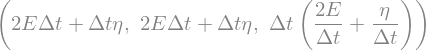

In [10]:
pi_rpre.hes_Pi, pi_ipre.hes_Pi, pi_rpie.hes_Pi

In [11]:
d_t_0 = 0.01
E_0 = 30000
mparams = (E_0, 0.1)
eta_0 = 0.1
eps_0, d_eps_0 = 0, 1
d_eps_v_0_ = get_rpie_eps_v(eps_0, d_eps_0, 0, d_t_0, *mparams)
eps_v_range = np.linspace(d_eps_v_0_-3, d_eps_v_0_+3, 30)
d_eps_v_0_

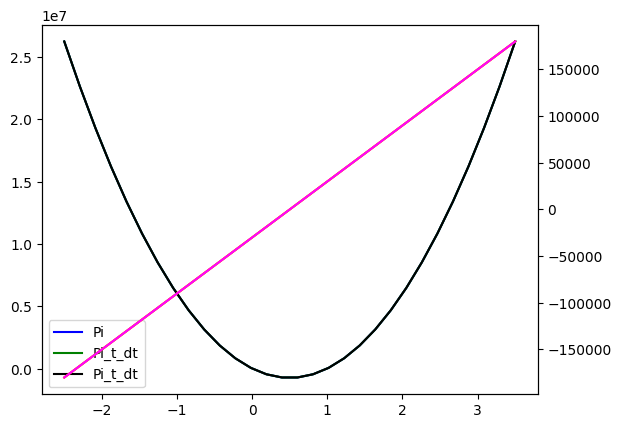

In [12]:
fig, ax = plt.subplots(1,1)
ax1 = ax.twinx()
ax.plot(eps_v_range, pi_rpre.get_Pi(eps_0, d_eps_0/d_t_0, 0, eps_v_range/d_t_0, d_t_0, E_0, eta_0), color='blue', label='Pi')
ax1.plot(eps_v_range, pi_rpre.get_jac_Pi(eps_0, d_eps_0/d_t_0, 0, eps_v_range/d_t_0, d_t_0, E_0, eta_0), color='red', label='dPi_ddot_eps_v')
ax.plot(eps_v_range, pi_ipre.get_Pi(eps_0, d_eps_0/d_t_0, 0, eps_v_range/d_t_0, d_t_0, E_0, eta_0), color='green', label='Pi_t_dt')
ax1.plot(eps_v_range, pi_ipre.get_jac_Pi(eps_0, d_eps_0/d_t_0, 0, eps_v_range/d_t_0, d_t_0, E_0, eta_0), color='orange', label='dPi_t_dt_ddot_eps_v')
ax.plot(eps_v_range, pi_rpie.get_Pi(eps_0, d_eps_0, 0, eps_v_range, d_t_0, E_0, eta_0), color='black', label='Pi_t_dt')
ax1.plot(eps_v_range, pi_rpie.get_jac_Pi(eps_0, d_eps_0, 0, eps_v_range, d_t_0, E_0, eta_0), color='magenta', label='dPi_t_dt_ddot_eps_v')
ax.legend() 


## Define the time integrators

Minimization of total potential energy is performed considering four options

 - Minimize $\Pi()$ for the rate of viscous strain $\dot{\varepsilon}^{(n)}_\mathrm{v}$
 - Minimize $\Pi()$ for an increment of viscous strain $\Delta \varepsilon_\mathrm{v}$

In [13]:
# Common optimization function
def optimize_increment(pi, eps_t, d_eps_t, eps_v_t, d_eps_v_next, d_t, *args):
    def objective(x):
        d_eps_v, = x
        Pi_val = pi.get_Pi(eps_t, d_eps_t, eps_v_t, d_eps_v, d_t, *args)
        return Pi_val

    def gradient(x):
        d_eps_v, = x
        dPi = np.array([pi.get_jac_Pi(eps_t, d_eps_t, eps_v_t, d_eps_v, d_t, *args)])
        return dPi

    res = minimize(objective, [d_eps_v_next], jac=gradient, method='Newton-CG')
    return res.x[0]

# Optimization based time integrators for viscoelasticity
def ti_minp(pi, eps_t, time_t, *args):
    d_eps_t = np.diff(eps_t, axis=0)
    d_t_t = np.diff(time_t, axis=0)
    if pi.rate_form:
        dd_eps_t = d_eps_t / d_t_t
    else:
        dd_eps_t = d_eps_t

    n_steps = len(eps_t)
    eps_v_t = np.zeros(n_steps)
    sig_t = np.zeros(n_steps)
    dd_eps_v_next = 0

    for i, d_t in enumerate(d_t_t):
        dd_eps_v_next = optimize_increment(pi, eps_t[i], dd_eps_t[i], eps_v_t[i], dd_eps_v_next, d_t, *args)
        sig_t[i+1] = pi.get_sig_n1(eps_t[i], dd_eps_t[i], eps_v_t[i], dd_eps_v_next, d_t, *args)
        if pi.rate_form:
            eps_v_t[i+1] = eps_v_t[i] + dd_eps_v_next * d_t
        else:
            eps_v_t[i+1] = eps_v_t[i] + dd_eps_v_next

    return eps_t, eps_v_t, sig_t

In [14]:
# Newton-Raphson iteration function
def newton_iteration(pi, eps_t, dot_eps_t, eps_v_t, d_eps_v_next, d_t, *args, max_iter=10):
    for j in range(max_iter):
        R_ = pi.get_jac_Pi(eps_t, dot_eps_t, eps_v_t, d_eps_v_next, d_t, *args)
        norm_R_ = np.sqrt(R_**2)
        if norm_R_ < 1e-6:
            break
        dR_dEps_ = pi.get_hes_Pi(eps_t, dot_eps_t, eps_v_t, d_eps_v_next, d_t, *args)
        d_eps_v_next -= R_ / dR_dEps_
    if j == max_iter - 1:
        raise ValueError(f'Newton-Raphson did not converge in max_iter={max_iter}')
    return d_eps_v_next

# Residual based time integrator for visco-elasticity
def ti_nr(pi, eps_t, time_t, *args):
    d_eps_t = np.diff(eps_t, axis=0)
    d_t_t = np.diff(time_t, axis=0)
    if pi.rate_form:
        dd_eps_t = d_eps_t / d_t_t
    else:
        dd_eps_t = d_eps_t

    n_steps = len(eps_t)
    eps_v_t = np.zeros(n_steps)
    sig_t = np.zeros(n_steps)
    dd_eps_v_next = 0

    for i, d_t in enumerate(d_t_t):
        dd_eps_v_next = newton_iteration(pi, eps_t[i], dd_eps_t[i], eps_v_t[i], dd_eps_v_next, d_t, *args)
        sig_t[i+1] = pi.get_sig_n1(eps_t[i], dd_eps_t[i], eps_v_t[i], dd_eps_v_next, d_t, *args)
        if pi.rate_form:
            eps_v_t[i+1] = eps_v_t[i] + dd_eps_v_next * d_t
        else:
            eps_v_t[i+1] = eps_v_t[i] + dd_eps_v_next
    
    return eps_t, eps_v_t, sig_t

## Data collection and plotting

In [15]:
# Create a simple container class to hold the data arrays
class DataContainer:
    def __init__(self, **kw):
        self.__dict__.update(kw)

# Function to perform integration and store results
def perform_integration(ti, pi, eps_t, time_t, *args):
    eps_t, eps_v_t, sig_t = ti(pi, eps_t, time_t, *args)
    eps_e_t = eps_t - eps_v_t
    return DataContainer(
        time=time_t,
        eps_t_cycles=eps_t,
        eps_e_t=eps_e_t,
        eps_v_t=eps_v_t,
        sig_t=sig_t
    )

In [16]:
def plot_results(ax1, ax2, ax3, data, label_suffix, color='blue'):
    # Plot results
    ax1.plot(data.time, data.eps_t_cycles, color=color, label=f'Total Strain {label_suffix}', lw=1.2, linestyle='-')
    ax1.plot(data.time, data.eps_v_t, color=color, label=f'Viscous Strain {label_suffix}', lw=0.6, linestyle='--')
    ax1.fill_between(data.time, data.eps_t_cycles, data.eps_v_t, color=color, alpha=0.1, label=f'Elastic Strain {label_suffix}')
    #ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Strain')
    ax1.legend()
    ax1.set_title('Strain Components')

    # Remove the top and right spines
    ax1.spines['top'].set_color('none')
    ax1.spines['right'].set_color('none')

    # Move the bottom spine to the zero of the y-axis
    ax1.spines['bottom'].set_position('zero')

    # Add an arrow at the end of the x-axis
    ax1.annotate('', xy=(1, 0), xytext=(1, 0),
                 arrowprops=dict(arrowstyle="->", color='black', lw=0.5),
                 xycoords=('axes fraction', 'data'), textcoords='data')

    # Add a label near the arrow
    ax1.text(1, 0, 'Time [s]', va='center', ha='left', color='black', fontsize=ax1.xaxis.get_label().get_size(),
             transform=ax1.get_yaxis_transform())
    ax2.plot(data.time, data.sig_t, color=color, label=f'Stress {label_suffix}')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Stress [Pa]')
    ax2.legend()
    ax2.set_title('Stress Response')

    ax3.plot(data.eps_t_cycles, data.sig_t, color=color, label=f'Stress-strain {label_suffix}')
    ax3.set_xlabel('Strain [-]')
    ax3.set_ylabel('Stress [Pa]')
    ax3.legend()
    ax3.set_title('Stress-Strain Response')

### Example 1: Cyclic loading with two frequencies

In [17]:

E_val = 30e3  # Young's modulus in MPa
eta_val = 30e+6  # Viscosity modulus in Pa / s
mparams = (E_val, eta_val)
d_t_val = 0.01 # Time step in seconds
final_time = 20  # Final time in secondsfinal_time = 1

# Generate cyclic sinusoidal loading history
time_t = np.arange(0, final_time, d_t_val)
eps_t_2_cycles = 0.01 * np.sin(2 * np.pi * 1 * time_t / final_time)  # 2 cycles
eps_t_4_cycles = 0.01 * np.sin(2 * np.pi * 4 * time_t / final_time)  # 4 cycles

# Compute responses for both loading histories using get_delta_Pi and get_ddelta_Pi_ddot_eps_v
# data_ipre_2 = perform_integration(ti_minp, pi_ipre, eps_t_2_cycles, time_t, *mparams)
# data_ipre_4 = perform_integration(ti_minp, pi_ipre, eps_t_4_cycles, time_t, *mparams)

# Compute responses for both loading histories using get_Pi and get_jac_Pi_ddot_eps_v
data_rpre_2 = perform_integration(ti_nr, pi_rpre, eps_t_2_cycles, time_t, *mparams)
data_rpre_4 = perform_integration(ti_nr, pi_rpre, eps_t_4_cycles, time_t, *mparams)


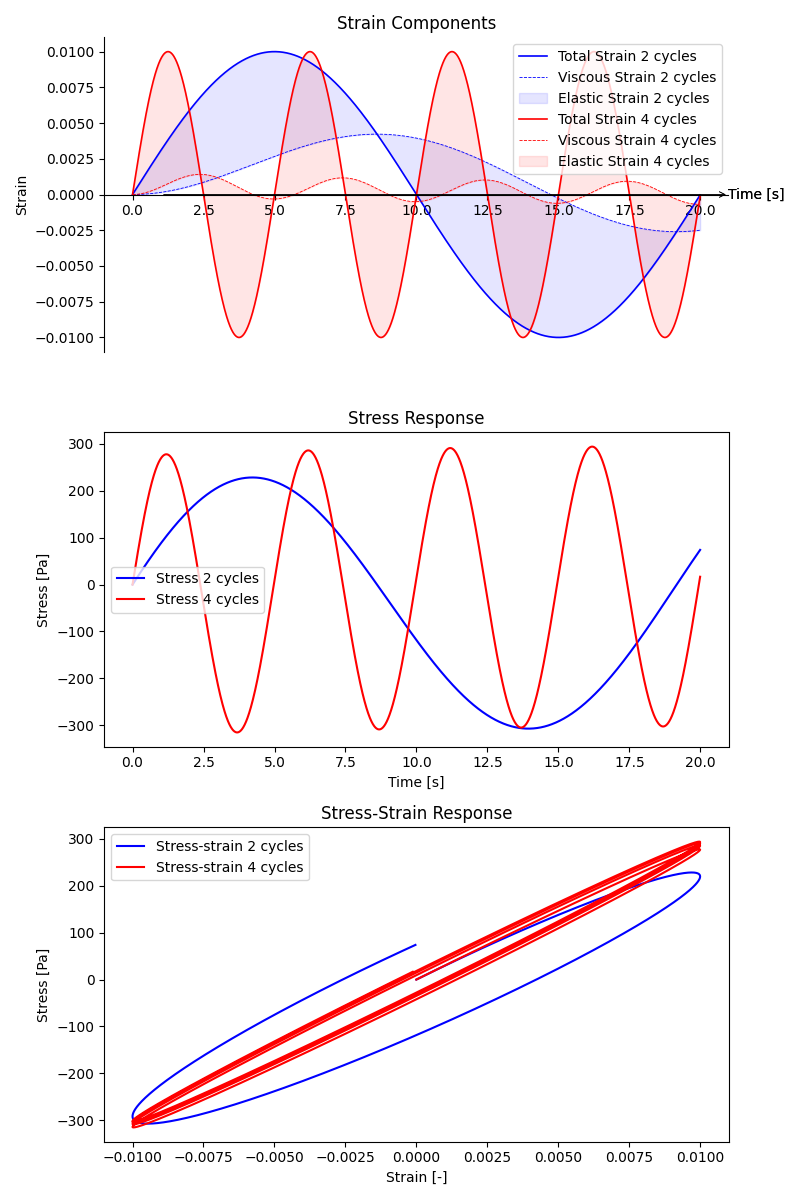

In [22]:
# Create the figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
fig.canvas.header_visible = False
# Plot the results for the two studies
plot_results(ax1, ax2, ax3, data_rpre_2, '2 cycles', 'blue' )
plot_results(ax1, ax2, ax3, data_rpre_4, '4 cycles', 'red')
fig.tight_layout()

### Example 2: Compare the solvers iterating in rates and increments 

In [19]:
E_val = 30e3  # Young's modulus in MPa
eta_val = 30e+5  # Viscosity modulus in Pa / s
mparams = (E_val, eta_val)

final_time = 30
time_t = np.linspace(0, final_time, 200)
eps_t_05_cycles = 0.01 * np.sin(2 * np.pi * 0.5 * time_t / final_time)
time_t_ = np.hstack([time_t, time_t[1:]*1+ final_time])
eps_t_05_cycles_ = np.hstack([eps_t_05_cycles, np.zeros_like(time_t[1:])])
data_rpre_05 = perform_integration(ti_minp, pi_rpre, eps_t_05_cycles_, time_t_, *mparams)
data_rpie_05 = perform_integration(ti_nr, pi_rpie, eps_t_05_cycles_, time_t_, *mparams)

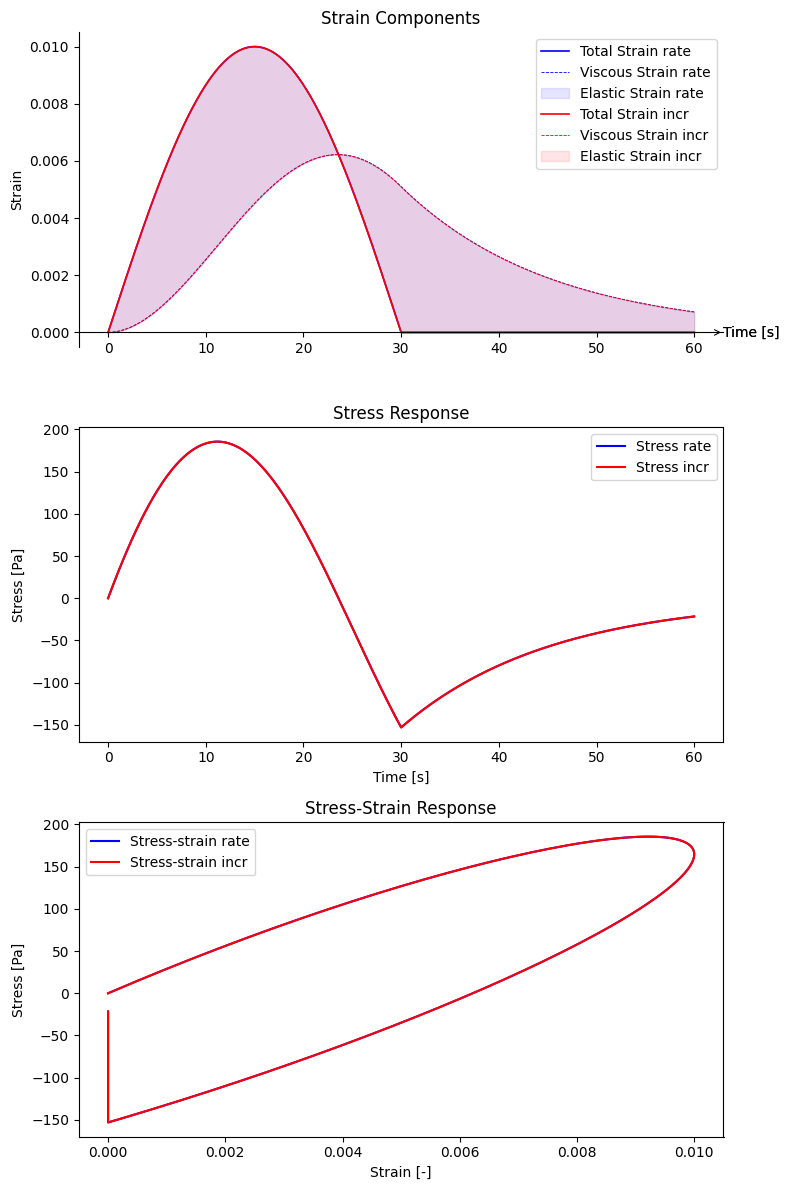

In [20]:
# Create the figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
fig.canvas.header_visible = False
# Plot the results for the two studies
plot_results(ax1, ax2, ax3, data_rpre_05, 'rate', color='blue')
plot_results(ax1, ax2, ax3, data_rpie_05, 'incr', color='red')
fig.tight_layout()